<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/HiggsBosonClassificationChallenge/higgs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**This is an example Notebook for running training on Higgs vs background signal classification. **

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries.

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this work, we focus on the potential of Quantum Machine Learning (QML) in detecting potential Higgs signal from one of the background processes that mimics it. This notebook imeplements a classical neural network for this task as an example, and your goal is to develop a quantum architecture to classify the Higgs signal.

**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine.
The full dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS). Here, we are going to use a reduced dataset for training and validation, and the final results will be evaluated on a separate test set after the submission.

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.




**Steps to load the training dataset**
1. Download the dataset from the UCI website.

In [ ]:
!pip install scipy==1.11.4

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 17.8 MB/s eta 0:00:00


In [2]:
!pip install plot-metric

2. Unzip the dataset folder

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# for reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

**Load the file using pandas library**

In [ ]:
!wget

In [3]:
data=pd.read_csv('data/challenge_higgs_data.csv')

Assign first column 0 to class labels (labeled 1 for signal, 0 for background)  and all others to feature matrix X.

In this example, for the sake of fast checking, we use 1000 samples. To train on the entire dataset, proceed with uncommenting the lines below.

In [4]:
X=data.iloc[:1000,1:]#data.iloc[:,1:]
y=data.iloc[:1000,0]#data.iloc[:,0]

Split your data into training and validation samples where the fraction of the data used for validation is 20%.

In [5]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "validation": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {"train": len(train_dataset),
                 "validation": len(val_dataset),
                 "test": len(test_dataset)}

**Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al

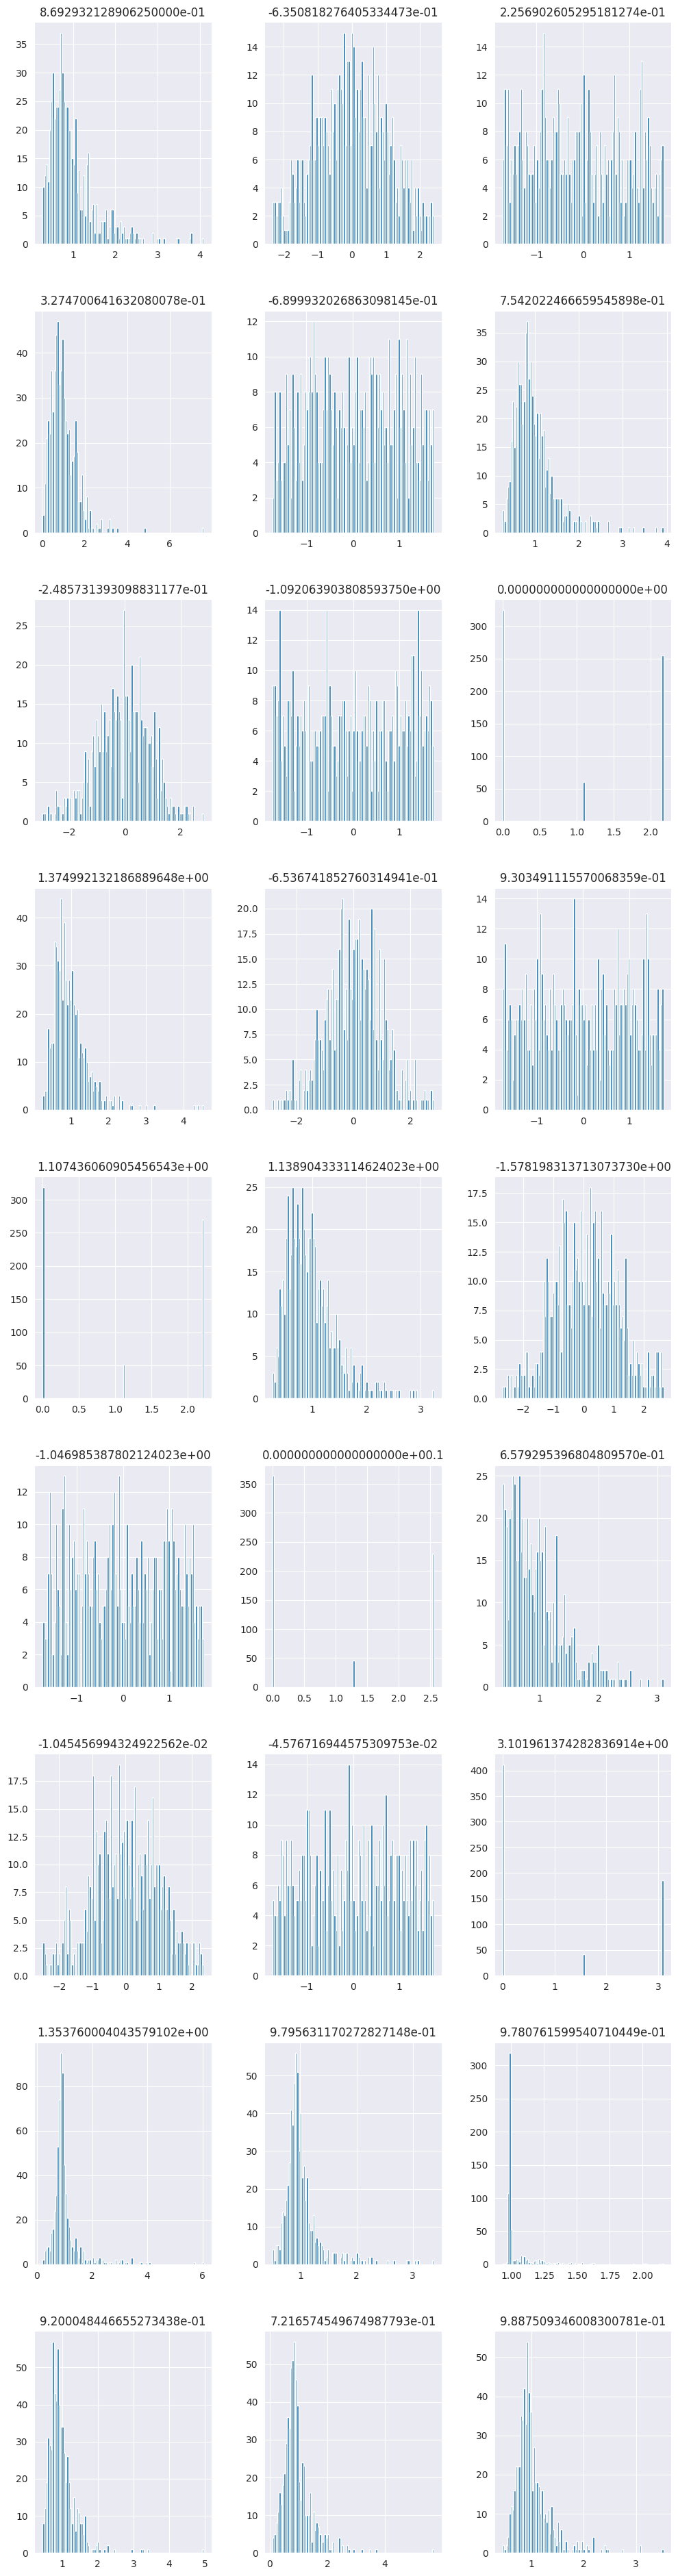

In [22]:
from itertools import combinations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(X_train.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X_train.hist(column = X_train.columns[i], bins = 100, ax=axis)
        i = i+1

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

**Setup the Neural Network** (some useful info [here](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc))

In [8]:
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from numpy import loadtxt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [9]:
device = 'cuda' # torch, classical device

In [10]:
class ClassicalNN(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.linear1 = nn.Linear(28, 32)

        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 8)
        self.linear5 = nn.Linear(8, 2)

    def forward(self, x):

      x = self.linear1(x)
      x = self.linear2(x)
      x = self.linear3(x)
      x = self.linear4(x)
      x = self.linear5(x)

      return x

**Train the Classical Neural Network**

In [11]:
classical_model = ClassicalNN().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
optimizer_hybrid = optim.Adam(classical_model.parameters(), lr=0.001)

In [14]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [15]:
classical_model = train_model(
    classical_model, criterion, optimizer_hybrid, num_epochs=40
)

Training started:
Phase: train Epoch: 1/40 Loss: 0.7077 Acc: 0.4891        
Phase: validation   Epoch: 1/40 Loss: 0.6875 Acc: 0.5650        
Phase: train Epoch: 2/40 Loss: 0.6941 Acc: 0.4875        
Phase: validation   Epoch: 2/40 Loss: 0.6942 Acc: 0.4750        
Phase: train Epoch: 3/40 Loss: 0.6868 Acc: 0.5484        
Phase: validation   Epoch: 3/40 Loss: 0.6896 Acc: 0.5900        
Phase: train Epoch: 4/40 Loss: 0.6835 Acc: 0.5734        
Phase: validation   Epoch: 4/40 Loss: 0.6892 Acc: 0.5750        
Phase: train Epoch: 5/40 Loss: 0.6769 Acc: 0.5797        
Phase: validation   Epoch: 5/40 Loss: 0.6920 Acc: 0.5400        
Phase: train Epoch: 6/40 Loss: 0.6680 Acc: 0.5984        
Phase: validation   Epoch: 6/40 Loss: 0.6881 Acc: 0.5550        
Phase: train Epoch: 7/40 Loss: 0.6600 Acc: 0.5984        
Phase: validation   Epoch: 7/40 Loss: 0.6940 Acc: 0.5650        
Phase: train Epoch: 8/40 Loss: 0.6531 Acc: 0.6031        
Phase: validation   Epoch: 8/40 Loss: 0.6903 Acc: 0.5750       

In [17]:
y_pred=classical_model(X_test_tensor.to(device))

In [19]:
y_pred = nn.Softmax(dim=1)(y_pred).cpu().detach().numpy()[:, 1]

**Print confusion matrix which describes the performance of the model classification by displaying the number of True Positives, True Negatives, False Positives and False Negatives. More info on [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)**

In [20]:
confusion_matrix(y_test, y_pred.round())

array([[42, 39],
       [26, 53]])

**Plot the ROC (Receiver Operating Characteristic) Curve** (more info on ROC could be found [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

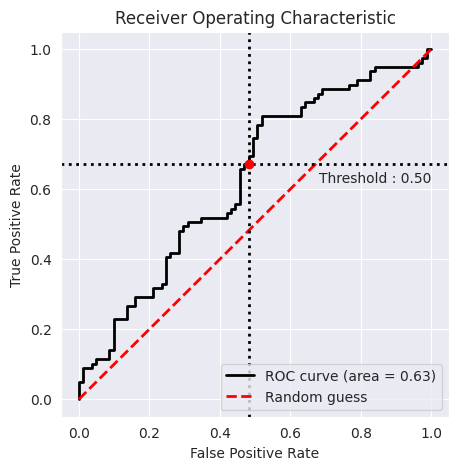

In [21]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Deliverables**

Please submit the following:

*   Your full notebook used for training including the ROC Curves, model weights and loss and accuracy plots wrt number of epochs.




**References**

Baldi, P., Sadowski, P. and Whiteson, D. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).



**Contributors**

Sergei V. Gleyzer *(University of Alabama)*

Ali Hariri *(American University of Beirut)*

Eric Reinhardt *(University of Alabama)*

Jogi Suda Neto *(University of Alabama)*

Marco Knipfer *(University of Alabama)*

Gopal Ramesh Dahale *(Indian Institute of Technology Bhilai)*